StyleGAN: https://arxiv.org/pdf/1508.06576.pdf

- An image incorporates two main concepts, content and style. We can use the different intermediate layers within a CNN architecture to extract the representation of content and style of an image. 

- We refer to the feature responses in higher layers of the network as the content representation. Since, higher layers in the network capture the high-level content in terms of objects and their arrangement in the input image but do not constrain the exact pixel values of the reconstruction.

- To obtain the style of an image, we use a feature space. The feature space consists of the correlations between the different filer outputs over the spatial extent of the feature maps. The style representation computes correlations between the different features in different layers of the CNN.This creates images that match the style of a given image on an increasing scale while discarding information of the global arrangement of the scene.

- However, reconstructions from the style features produce texturised versions of the input image that capture its general appearance in terms of colour and localised structures.

- Combining the style of one image with the content of a photograph, this renders the photograph in the style of the artwork, such that the appearance of the synthesised image resembles the work of art, even though it shows the same content as the photograph.

- Of course, image content and style cannot be completely disentangled. Placing a strong emphasis on style results in images matching the appearence of the artwork but hardly showing the content of the photograph-- vice versa. For a specific pair of source images one can adjust the trade-off between content and style to create visually appealing images.








In [ ]:
import os
from google.colab import drive
from google.colab import files
import tensorflow as tf
import IPython.display as display
import matplotlib.pyplot as plt
import numpy as np
import PIL.Image
import time
import functools

In [ ]:
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [ ]:
!rsync --info=progress2 -az /content/gdrive/Shareddrives/ArtisticGAN/ Images
!ls

              0   0%    0.00kB/s    0:00:00 (xfr#0, to-chk=0/13)
gdrive	Images	NewImages  sample_data


In [ ]:
!mkdir NewImages
!ls Images

mkdir: cannot create directory ‘NewImages’: File exists
composition-ix.jpg   grid.jpg	     maltipoo.jpg	     starry-night.jpg
composition-vii.jpg  impression.jpg  mountains-and-seas.jpg  the-return.jpg
dora-maar.jpg	     jason.jpg	     nighthawks.jpg	     the-scream.jpg


In [ ]:
def tensor_to_image(tensor):
  tensor = tensor*255.0
  tensor = np.array(tensor, dtype=np.uint8)
  if np.ndim(tensor) > 3: # if the image tensor has a batch dimension
    assert tensor.shape[0] == 1
    tensor = tensor[0]
  return PIL.Image.fromarray(tensor)

In [ ]:
def load_img(filepath):
  img_size = 512

  # decode
  image = tf.io.read_file(filepath)
  image = tf.io.decode_image(image, channels=3)
  image = tf.image.convert_image_dtype(image, dtype=tf.float32) # this function scales then casts, floating point values are expected to have values [0,1]

  image = tf.image.resize(image, (img_size,img_size))
  image = image[tf.newaxis,:] # just like expand dim.. adds dim with a value of 1 at the front of the tensor for batch dim
  return image

def show(image, title=None):
  if len(image.shape) > 3: # if batch dim remove it 
    image = tf.squeeze(image, axis=0) 

  plt.imshow(image)
  if title:
    plt.title(title)

In [ ]:
def vgg_layers(layer_names):
  vgg = tf.keras.applications.VGG19(include_top=False, weights='imagenet')
  vgg.trainable = False

  outputs = [vgg.get_layer(name).output for name in layer_names]

  model = tf.keras.Model(inputs=vgg.input, outputs=outputs)
  return model

content_layers = ['block5_conv2']

style_layers = ['block1_conv1',
                'block2_conv1',
                'block3_conv1',
                'block4_conv1',
                'block5_conv1',]
                
num_content_layers = len(content_layers)
num_style_layers = len(style_layers)

Calculate style

The content of an image is represented by the values of the intermediate feature maps.

It turns out, the style of an image can be described by the means and correlations across the different feature maps. Calculate a Gram matrix that includes this information by taking the outer product of the feature vector with itself at each location, and averaging that outer product over all locations. This Gram matrix can be calculated for a particular layer as:

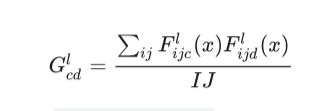


In [ ]:
# function that calculates the 'style' of an image
def gram_matrix(input_tensor):
  result = tf.linalg.einsum('bijc,bijd->bcd', input_tensor, input_tensor)
  input_shape = tf.shape(input_tensor)
  num_locations = tf.cast(input_shape[1]*input_shape[2], tf.float32)
  return result/(num_locations)

Extract style and content

In [ ]:
class StyleContentModel(tf.keras.models.Model):
  def __init__(self, style_layers, content_layers):
    super(StyleContentModel, self).__init__()
    self.model = vgg_layers(style_layers + content_layers)
    self.style_layers = style_layers
    self.content_layers = content_layers
    self.num_style_layers = len(style_layers)
    self.model.trainable = False

  # model returns gram matrix (style calculator) of style layer and content of content layers
  def call(self, inputs):
    inputs = inputs*255 # input is float [0,1] so turn back to int [0,255] for preprocessing
    inputs = tf.keras.applications.vgg19.preprocess_input(inputs)
    
    outputs = self.model(inputs)
    style_outputs, content_outputs = outputs[:self.num_style_layers], outputs[self.num_style_layers:]

    style_outputs = [gram_matrix(style_output) for style_output in style_outputs]
    style_dict = {style_name: output for style_name, output in zip(self.style_layers, style_outputs)}

    content_dict = {content_name: output for content_name, output in zip(self.content_layers, content_outputs)}

    return {'content': content_dict, 'style': style_dict}

Create style transfer algorithm

With this style and content extractor, you can now implement the style transfer algorithm. Do this by calculating the mean square error for your image's output relative to each target, then take the weighted sum of these losses.

In [ ]:
# image will be float so we need a function to stay in 0-1 range (normalized)
def clip_0_1(image):
  return tf.clip_by_value(image, clip_value_min=0., clip_value_max=1.)

In [ ]:
opt = tf.optimizers.Adam(learning_rate=1e-3, beta_1=0.99, epsilon=1e-1)

style_weight = 1e-1
content_weight = 1e1

print("Current style/content ratio:", style_weight/content_weight)

def calc_loss(outputs):
  gen_style_outputs = outputs['style']
  gen_content_outputs = outputs['content']

  style_loss = tf.add_n([tf.reduce_mean((gen_style_outputs[name]-style_targets[name])**2) for name in gen_style_outputs.keys()])
  style_loss *= style_weight/ num_style_layers

  content_loss = tf.add_n([tf.reduce_mean((gen_content_outputs[name]-content_targets[name])**2) for name in gen_content_outputs.keys()])
  content_loss *= content_weight/ num_content_layers

  loss = style_loss + content_loss
  return loss

Current style/content ratio: 0.01


In [ ]:
!ls Images

composition-ix.jpg   grid.jpg	     maltipoo.jpg	     starry-night.jpg
composition-vii.jpg  impression.jpg  mountains-and-seas.jpg  the-return.jpg
dora-maar.jpg	     jason.jpg	     nighthawks.jpg	     the-scream.jpg


In [ ]:
dir_path = 'Images/'
content_path = dir_path+'maltipoo.jpg'
style_path = dir_path+'composition-ix.jpg'

(1, 512, 512, 3)
(1, 512, 512, 3)


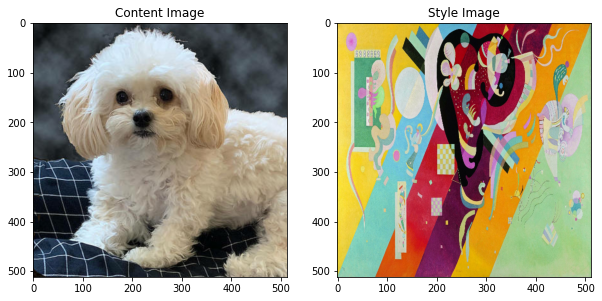

In [ ]:
content_image = load_img(content_path)
style_image = load_img(style_path)

plt.figure(figsize=(10, 10))

plt.subplot(1, 2, 1)
show(content_image, 'Content Image')
print(content_image.shape)

plt.subplot(1, 2, 2)
show(style_image, 'Style Image')
print(style_image.shape)

In [ ]:
extractor = StyleContentModel(style_layers, content_layers)

style_targets = extractor(style_image)['style']
content_targets = extractor(content_image)['content']

# initialize an image that will be the result of combining content and style
# A tf.Variable represents a tensor whose value can be changed by running ops on it
image = tf.Variable(content_image)

Total variation loss

One downside to this basic implementation is that it produces a lot of high frequency artifacts. Decrease these using an explicit regularization term on the high frequency components of the image. In style transfer, this is often called the total variation loss

In [ ]:
# run this cell again if image is change
# due to this function being decorated

total_var_weight = 10

@tf.function()
def train_step(image):
  with tf.GradientTape() as tape:
    outputs = extractor(image) # run img thru model
    loss = calc_loss(outputs) # calc loss
    loss += total_var_weight*tf.image.total_variation(image) # calc total loss with variation

  grad = tape.gradient(loss, image) # gradient descent
  opt.apply_gradients([(grad, image)])
  image.assign(clip_0_1(image)) # upadte image

In [ ]:
def train_model():
  start = time.time()

  epochs = 50
  steps_per_epoch = 200
  step = 0

  for e in range(epochs):
    for s in range(steps_per_epoch):
      step += 1
      train_step(image)
      print(".", end='', flush=True)
    display.clear_output(wait=True)
    display.display(tensor_to_image(image))
    print("Epoch: {}".format(e+1))

  end = time.time()
  print("Total time elasped: {:.1f} seconds".format(end-start))

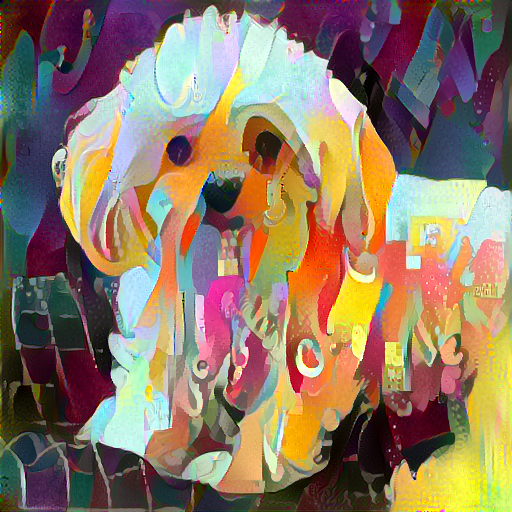

Epoch: 50
Total time elasped: 235.0 seconds


In [ ]:
# rerun train_step cell since that function is complied based off of image
train_model()

Save image to drive

In [ ]:
image_path = 'maltipoo+composition-ix.jpg'
image_path = 'NewImages/{}'.format(image_path)
save_image = tensor_to_image(image).save(image_path)

In [ ]:
!ls NewImages

maltipoo+composition-ix.jpg   maltipoo+starry-night.jpg
maltipoo+composition-vii.jpg  maltipoo+the-scream.jpg
maltipoo+impression.jpg


In [ ]:
# reset mdoel
tf.keras.backend.clear_session()

Weights by composition:

- maltipoo
 - starry-night: 10
 - composition-vii: 10000.0
 - composition-ix: 0.01
 - impression: 0.0001
 - the-scream: 10